# Hybrid: MT vs HT 

In [94]:
import numpy as np
from homopy.elasticity import *
from homopy.methods import *
from homopy.stiffness_plot import *
from homopy.tensor import *

In [95]:
# define fiber and matrix properties for HT

# carbon (assuming isotropic fiber)
E_carbon = 242e9; G_carbon = 105e9; nu_carbon = 0.1; l_carbon = 1.5e-3; 
r_carbon = 7.2 / 2 * 1e-6; vol_carbon = 0.25; 

# glass (is isotropic)
E_glass = 80e9; nu_glass = 0.22; G_glass = 1/2*E_glass/(1+nu_glass); l_glass = 0.8e-3;
r_glass = 20 / 2 * 1e-6; vol_glass = 0.25

# PA6
E_pa6 = 1.18e9; nu_pa6 = 0.35; G_pa6 = 1/2*E_pa6/(1+nu_pa6); 


In [96]:
# define fiber and matrix properties for MT

# carbon 
carbon_fiber = Isotropy(E_carbon, nu_carbon)
v_frac_carbon = vol_carbon
a_carbon = l_carbon/(2*r_carbon)

# glass
glass_fiber = Isotropy(E_glass, nu_glass)
v_frac_glass = vol_glass
a_glass = l_glass/(2*r_glass)

# PA6
polyamid6 = Isotropy(E_pa6, nu_pa6)

In [97]:
# create HT and MT objects

ht_carbon = HalpinTsai(
        E_carbon,
        E_pa6,
        G_carbon,
        G_pa6,
        nu_carbon,
        nu_pa6,
        l_carbon,
        r_carbon,
        vol_carbon,
    )

ht_glass = HalpinTsai(
        E_glass,
        E_pa6,
        G_glass,
        G_pa6,
        nu_glass,
        nu_pa6,
        l_glass,
        r_glass,
        vol_glass,
    )


mt_hybrid = MoriTanaka(polyamid6, [carbon_fiber, glass_fiber], [v_frac_carbon/2, v_frac_glass/2], [a_carbon, a_glass], 2*['ellipsoid'])


In [98]:
# give n fibers a random distribtution and go from here

pi = np.pi
angle_disc = 1/40*pi # angle discretization
distribution = 'gauss'

# missuse ElasticPlot()
plotter = ElasticPlot()

n = 1000
theta = pi/2

def random_fibers(n, distribution = 'random', sigma = 0.1*pi):
    fiber_dirs = []
    angles = []
    for i in range(n):
        if distribution == 'random':
            phi = pi*np.random.rand() - pi/2 # equally likely -> isotropic
        elif distribution == 'gauss':
            phi = np.clip(np.random.normal(0, sigma), -pi/2, pi/2) # gaussian distribution -> change values to shift
        fiber_dirs.append(plotter._dir_vec(phi,theta))
        angles.append(phi)
    return np.array(fiber_dirs), angles
    
fiber_dirs_carbon, angles_carbon = random_fibers(n, distribution='random', sigma=0.1*pi)
fiber_dirs_glass, angles_glass = random_fibers(n, distribution='random', sigma= 0.1*pi)


# define function to calculate a discrete planar fiber distribution with a given angle spectrum

def get_distribution_histogram(angles, angle_disc):
    """
    Return the discrete orientation probability histogram for measured fiber_dirs.
    
    Paramters:
        - angles : array of shape (n,1)
            Measured fiber angles.
        - angle_spec : float in [0,pi]
            Angle spectrum.

    Returns:
        - angle_probs : ndarray of shape (pi/angle_spec, 1)
            Histogram of fiber orientation.
    """
    measurements = len(angles)
    angle_probs = []
    for i in np.arange(-pi/2-angle_disc/2,pi/2, angle_disc):
        # print("[{}, {}, {}]".format(i, i+angle_spec/2, i + angle_spec))
        hits = 0
        for angle in angles:
            if angle > i and angle <= i + angle_disc:
                hits += 1
        angle_probs.append([i+angle_disc/2,hits/measurements])
    return angle_probs
            
            

hist_carbon = np.array(get_distribution_histogram(angles_carbon, angle_disc))
hist_glass = np.array(get_distribution_histogram(angles_glass, angle_disc))
    

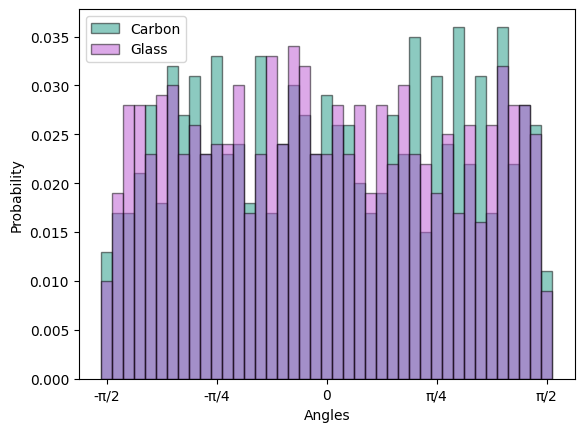

In [99]:
# plot angle distribution

import matplotlib.pyplot as plt

x_carbon = hist_carbon[:,0]
y_carbon = hist_carbon[:,1]

x_glass = hist_glass[:,0]
y_glass = hist_glass[:,1]

plt.bar(x_carbon,y_carbon,width=angle_disc,align='center', color=(27/256,151/256,131/256),edgecolor='k', alpha=0.5, label='Carbon')
plt.bar(x_glass,y_glass,width=angle_disc,align='center', color='mediumorchid',edgecolor='k', alpha=0.5, label='Glass')
plt.xlabel('Angles')
plt.ylabel('Probability')
plt.xticks(np.arange(-pi/2, pi/2+pi/4, step=(pi/4)), ['-π/2','-π/4', '0', 'π/4','π/2'])


plt.legend()
plt.show()


In [100]:
# build orientation tensor of 4th and 2nd order

N4_carbon = np.zeros((3,3,3,3))
N4_glass = np.zeros((3,3,3,3))

for fiber_dir in fiber_dirs_carbon:
    N4_carbon += np.einsum('i,j,k,l->ijkl', fiber_dir, fiber_dir, fiber_dir, fiber_dir)

N4_carbon /= len(fiber_dirs_carbon)
    
for fiber_dir in fiber_dirs_glass:
    N4_glass += np.einsum('i,j,k,l->ijkl', fiber_dir.T, fiber_dir.T, fiber_dir.T, fiber_dir.T)
    
N4_glass /= len(fiber_dirs_glass)

N2_carbon = np.einsum('ijkk->ij', N4_carbon)
N2_glass = np.einsum('ijkk->ij', N4_glass)

In [101]:
"""
from fiberoripy.closures import (
    IBOF_closure,
    get_random_tensor_pair,
    hybrid_closure,
    linear_closure,
    quadratic_closure,
)
from fiberoripy.tensorplot import (
    plot_orbit2,
    plot_orbit4,
    plot_projection2,
    plot_projection4,
)

# graphical representation of orientation tensors of 4th order

N4_carbon_flat = Tensor().tensor2mandel(N4_carbon)
N4_glass_flat = Tensor().tensor2mandel(N4_glass)

N2 = np.zeros((3,3))
N2[0,0] = 9/10
N2[1,1] = 1/20
N2[2,2] = 1/20
N4 = Tensor().tensor2mandel(IBOF_closure(N2))

_ = plotter.plot_E_body(np.linalg.inv(N4_carbon_flat), 200, 200, bound=[0.5,0.5,0.5])
"""
pass

In [102]:
# build laminate from HT results

laminas_carbon = len(angles_carbon)*[ht_carbon.get_effective_stiffness()]
laminas_glass = len(angles_glass)*[ht_glass.get_effective_stiffness()]

laminas_combined = laminas_carbon + laminas_glass
angles_combined = angles_carbon + angles_glass

ht_laminate = Laminate(laminas_combined, angles_combined)

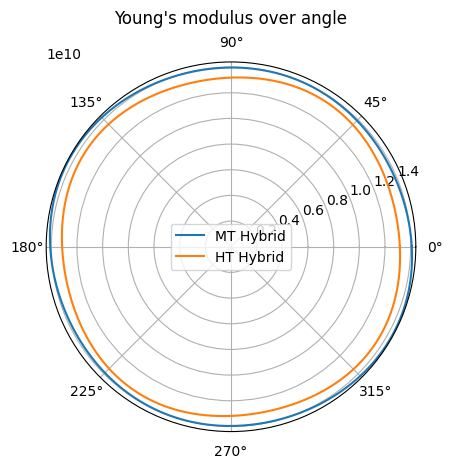

In [103]:
# Compare MT and HT after orientation averaging

# mt_hybrid_plot = plotter.polar_plot_E_body(np.linalg.inv(mt_hybrid.effective_stiffness66), 200, 0, plot=True)


mt_hybrid_ave = mt_hybrid.get_average_stiffness((N2_carbon+N2_glass)/2, (N4_carbon+N4_glass)/2)

mt_hybrid_plot_ave = plotter.polar_plot_E_body(np.linalg.inv(mt_hybrid_ave), 200, 0, plot=False)
ht_hybrid_plot_ave = plotter.polar_plot_laminate(ht_laminate.get_effective_stiffness(), 1000, plot=False)


plotter.polar_plot(
    [mt_hybrid_plot_ave + ("MT Hybrid",), ht_hybrid_plot_ave + ("HT Hybrid",)]
) 